# Freshwater Quality Dataset Baseline 

## Data Exploratory Analysis 

The analysis covers various aspects of data processing and analysis, including data loading, cleaning, visualization, and time series analysis. The goal of this analysis is to provide insights into the water quality data that can be used to make informed decisions related to water management and conservation.

### Contents

##### The exploratory analysis includes the following steps:

1. Data loading and inspection
2. Data cleaning and preprocessing
3. Data visualization
4. Time series analysis

### Introduction:

Freshwater quality is a crucial aspect of environmental health and human well-being. Freshwater bodies such as rivers, lakes, and groundwater are essential sources of drinking water, irrigation, and industrial use. Water quality can be impacted by natural factors such as weather and geology, as well as human activities such as agriculture, industry, and urbanization.

The quality of freshwater is determined by physical, chemical, and biological characteristics, which can impact the suitability of water for different purposes. Common water quality parameters include temperature, pH, dissolved oxygen, nutrients, and contaminants such as heavy metals and pesticides.

Effective management of freshwater resources requires continuous monitoring and analysis of water quality data. Exploratory data analysis can provide insights into patterns and trends in water quality, identifying potential sources of contamination, and supporting decision-making for water resource management.




In [1]:
!python -V

Python 3.8.16


In [2]:
# Import necessary libraries
import os
import shutil
import daal4py as d4p

import modin.pandas as mpd
from modin.config import Engine
Engine.put("dask") 

import time
import warnings
import pandas as pd
import numpy as np
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')
pio.renderers.default='notebook' 
intel_pal, color=['#0071C5','#FCBB13'], ['#7AB5E1','#FCE7B2']
temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), 
                           height=500, width=1000))


from sklearn.impute import SimpleImputer
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
from datetime import datetime
import calendar

In [3]:
from profiling.profile_utils import PlatformUtils
plat_utils = PlatformUtils()
plat_utils.dump_platform_info()

==================== CPU Info ====================
Physical cores: 8
Total cores: 16
Max Frequency: 2904.0
Min Frequency: 0.0
==================== Memory Information ====================
Total:  23 GB


## 1. Data Loading and Inspection
In this step, we load the fresh water quality data into our analysis environment and inspect its properties. We check for missing values, data types, and other important characteristics that can affect our analysis.

In [ ]:
# Download the dataset file from the online source
!wget https://s3-ap-southeast-1.amazonaws.com/he-public-data/datasetab75fb3.zip -O dataset.zip

In [ ]:
# unzip the dataset compressed file
!unzip dataset.zip

In [ ]:
# remove the zip file in the directory to save more space in the drive
!rm dataset.zip

In [ ]:
# move the data to the data folder in the directory file

if not os.path.exists("data"):
    os.mkdir("data")
    print("Created directory 'data'")
else:
    print("Directory 'data' already exists")

if not os.path.exists("data/dataset.csv"):
    shutil.move("dataset.csv", "data/dataset.csv")
    print("Moved 'dataset.csv' to 'data' folder")
else:
    print("'dataset.csv' already exists in 'data' folder")

In [4]:
# Load the dataset using Data Chunking
chunk_size = 1000000
reader = pd.read_csv('./data/dataset.csv', chunksize=chunk_size)

# Sample a smaller subset of the data that is representative of the whole dataset
sampled_data = pd.DataFrame()
for i, chunk in enumerate(reader):
    if i == 0:
        sampled_data = chunk.sample(frac=1/4, random_state=42)
    else:
        sampled_data = pd.concat([sampled_data, chunk.sample(frac=1/4, random_state=42)])

# Split the data into three equal parts
parts = np.array_split(sampled_data, 4)

# Save each part into a separate file
for i, part in enumerate(parts):
    part.to_csv(f'data/sampled_data_part_{i}.csv', index=False)
    
del reader

In [5]:
# Load the dataset with pandas
start_time = time.time()
chunk_size = 1000000  # Set chunk size
chunks = pd.read_csv('./data/sampled_data_part_0.csv', chunksize=chunk_size)
df_pandas = pd.concat(chunks)
pandas_load_time = time.time() - start_time
pandas_memory_usage = df_pandas.memory_usage(deep=True).sum() / 1024 / 1024  # Convert to MB

# Load the dataset with Modin
start_time = time.time()
df_modin = mpd.read_csv('./data/sampled_data_part_0.csv')
modin_load_time = time.time() - start_time
modin_memory_usage = df_modin.memory_usage(deep=True).sum() / 1024 / 1024  # Convert to MB

# Display the comparison in a table
table = [['', 'Loading Time (s)', 'Memory Usage (MB)', 'Chunk Size', 'Latency (s)'],  # Add headers
         ['Pandas', pandas_load_time, pandas_memory_usage, chunk_size, pandas_load_time/len(df_pandas)],
         ['Modin', modin_load_time, modin_memory_usage, '-', modin_load_time/len(df_modin)]]

print(tabulate(table, headers='firstrow', tablefmt='grid'))

+--------+--------------------+---------------------+--------------+---------------+
|        |   Loading Time (s) |   Memory Usage (MB) | Chunk Size   |   Latency (s) |
+========+====================+=====================+==============+===============+
| Pandas |            1.3003  |             128.251 | 1000000      |   3.49259e-06 |
+--------+--------------------+---------------------+--------------+---------------+
| Modin  |            7.45914 |             128.251 | -            |   2.00351e-05 |
+--------+--------------------+---------------------+--------------+---------------+


In [7]:
data = mpd.read_csv('./data/sampled_data_part_0.csv') #df_modin.copy()
#del df_modin  #df_pandas,

In [8]:
data.head()

,Index,pH,Iron,Nitrate,Chloride,Lead,Zinc,Color,Turbidity,Fluoride,...,Chlorine,Manganese,Total Dissolved Solids,Source,Water Temperature,Air Temperature,Month,Day,Time of Day,Target
0,987231,8.000297,1.038665e-06,6.096929,195.121702,1.064793e-89,2.233189,Near Colorless,0.008857,1.226534,...,3.157448,2.132286e-02,492.899339,Reservoir,10.707006,58.849718,December,6.0,18.0,0
1,79954,8.166638,3.321503e-02,3.175775,232.401603,1.547907e-13,0.165789,Colorless,0.134098,1.508460,...,2.942175,4.221105e-02,252.318055,Lake,14.108145,66.475611,March,7.0,23.0,0
2,567130,8.498052,3.104806e-01,5.997879,101.808850,3.275087e-80,0.000348,Near Colorless,0.146882,0.613420,...,3.839162,2.505741e-02,253.545984,Aquifer,16.012314,85.079691,November,14.0,2.0,0
3,500891,7.479848,8.557992e-02,7.553259,154.923108,7.890441e-157,0.455024,Near Colorless,0.379885,1.790133,...,2.502062,1.163918e-10,106.157748,Spring,10.458635,39.667278,February,5.0,7.0,0
4,55399,6.834705,7.155661e-08,3.540776,NaN,2.394045e-32,1.345909,Near Colorless,0.231229,0.141736,...,2.574456,1.604002e-07,383.266953,Aquifer,12.801169,63.235199,March,6.0,22.0,0


In [9]:
data.describe()

,Index,pH,Iron,Nitrate,Chloride,Lead,Zinc,Turbidity,Fluoride,Copper,...,Sulfate,Conductivity,Chlorine,Manganese,Total Dissolved Solids,Water Temperature,Air Temperature,Day,Time of Day,Target
count,3.723030e+05,364928.000000,3.698860e+05,365739.000000,361324.000000,3.706650e+05,362474.000000,3.692100e+05,360552.000000,3.597210e+05,...,360109.000000,362021.000000,368665.000000,3.654840e+05,372211.000000,361646.000000,370553.000000,365989.000000,365168.000000,372303.000000
mean,8.282786e+05,7.444588,1.240042e-01,6.141437,183.395429,1.498922e-03,1.544380,5.089542e-01,0.958518,5.102554e-01,...,145.781799,424.526831,3.251864,1.045443e-01,266.527442,19.171552,60.007336,15.760315,11.486527,0.280062
std,5.510959e+05,0.877636,4.680119e-01,3.219055,67.442210,3.301639e-02,1.537178,9.078007e-01,0.814799,5.890948e-01,...,68.325222,189.472101,0.729138,4.659227e-01,155.402379,11.411679,18.077490,8.803698,6.917579,0.449030
min,0.000000e+00,1.057113,2.047587e-53,0.407135,36.299826,0.000000e+00,0.000004,5.686552e-15,0.000039,2.407425e-07,...,14.550941,18.901552,1.035579,4.074549e-46,0.014658,0.666194,-17.132226,1.000000,0.000000,0.000000
25%,3.722755e+05,6.897028,9.941251e-06,3.967005,137.938264,1.186988e-122,0.414018,3.814766e-02,0.374827,1.280415e-01,...,97.704990,286.293662,2.745562,2.387835e-06,132.846955,11.336570,47.803597,8.000000,5.000000,0.000000
50%,7.442900e+05,7.448689,2.197140e-03,5.595687,175.507923,2.899801e-62,1.078777,2.065933e-01,0.773676,3.454764e-01,...,134.466666,396.633985,3.208619,6.129227e-04,265.277762,16.491858,59.975111,16.000000,11.000000,0.000000
75%,1.237646e+06,8.010400,5.291586e-02,7.644072,217.174992,4.588270e-27,2.228302,6.127488e-01,1.336427,6.955201e-01,...,181.544349,532.537938,3.699029,1.573187e-02,397.483851,23.901697,72.194702,23.000000,17.000000,1.000000
max,1.999998e+06,12.891960,1.417404e+01,73.072931,1430.548852,3.958013e+00,23.182713,1.949299e+01,10.854950,1.071732e+01,...,1279.553774,1891.515730,11.485010,2.026258e+01,579.797750,210.821909,140.642151,31.000000,23.000000,1.000000


In [10]:
data.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 372303 entries, 0 to 372302
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ----------------------  ---------------  -----  
 0   Index                   372303 non-null  int64
 1   pH                      364928 non-null  float64
 2   Iron                    369886 non-null  float64
 3   Nitrate                 365739 non-null  float64
 4   Chloride                361324 non-null  float64
 5   Lead                    370665 non-null  float64
 6   Zinc                    362474 non-null  float64
 7   Color                   371948 non-null  object
 8   Turbidity               369210 non-null  float64
 9   Fluoride                360552 non-null  float64
 10  Copper                  359721 non-null  float64
 11  Odor                    361099 non-null  float64
 12  Sulfate                 360109 non-null  float64
 13  Conductivity            362021 non-null  float64
 14  Chlorine          

## 2. Data Cleaning and Preprocessing
In this step, we preprocess the data to remove any inconsistencies, missing values, and other anomalies that can affect our analysis. We also transform the data into a format that can be easily analyzed and visualized.

In [11]:
# Check for missing values
print(data.isna().sum())

Index                         0
pH                         7375
Iron                       2417
Nitrate                    6564
Chloride                  10979
Lead                       1638
Zinc                       9829
Color                       355
Turbidity                  3093
Fluoride                  11751
Copper                    12582
Odor                      11204
Sulfate                   12194
Conductivity              10282
Chlorine                   3638
Manganese                  6819
Total Dissolved Solids       92
Source                     5521
Water Temperature         10657
Air Temperature            1750
Month                      5959
Day                        6314
Time of Day                7135
Target                        0
dtype: int64


In [12]:
# Print the shape of the sampled data
print("Shape of sampled data: ", data.shape)

# Fill missing values using sklearn's linear interpolation method
data = data.interpolate(method="linear", limit_direction="both")

Shape of sampled data:  (372303, 24)


In [13]:
# Remove rows with any missing values
data = data.dropna()

In [14]:
# Print the shape of the cleaned data
print("Shape of cleaned data: ", data.shape)

Shape of cleaned data:  (360551, 24)


In [15]:
# Check again for missing values
print(data.isna().sum())

Index                     0
pH                        0
Iron                      0
Nitrate                   0
Chloride                  0
Lead                      0
Zinc                      0
Color                     0
Turbidity                 0
Fluoride                  0
Copper                    0
Odor                      0
Sulfate                   0
Conductivity              0
Chlorine                  0
Manganese                 0
Total Dissolved Solids    0
Source                    0
Water Temperature         0
Air Temperature           0
Month                     0
Day                       0
Time of Day               0
Target                    0
dtype: int64


## 3. Data Visualization
In this step, we visualize the data to gain insights into its properties and relationships between different variables. We create plots and charts to understand the distribution of different variables, their correlations, and other important aspects of the data.

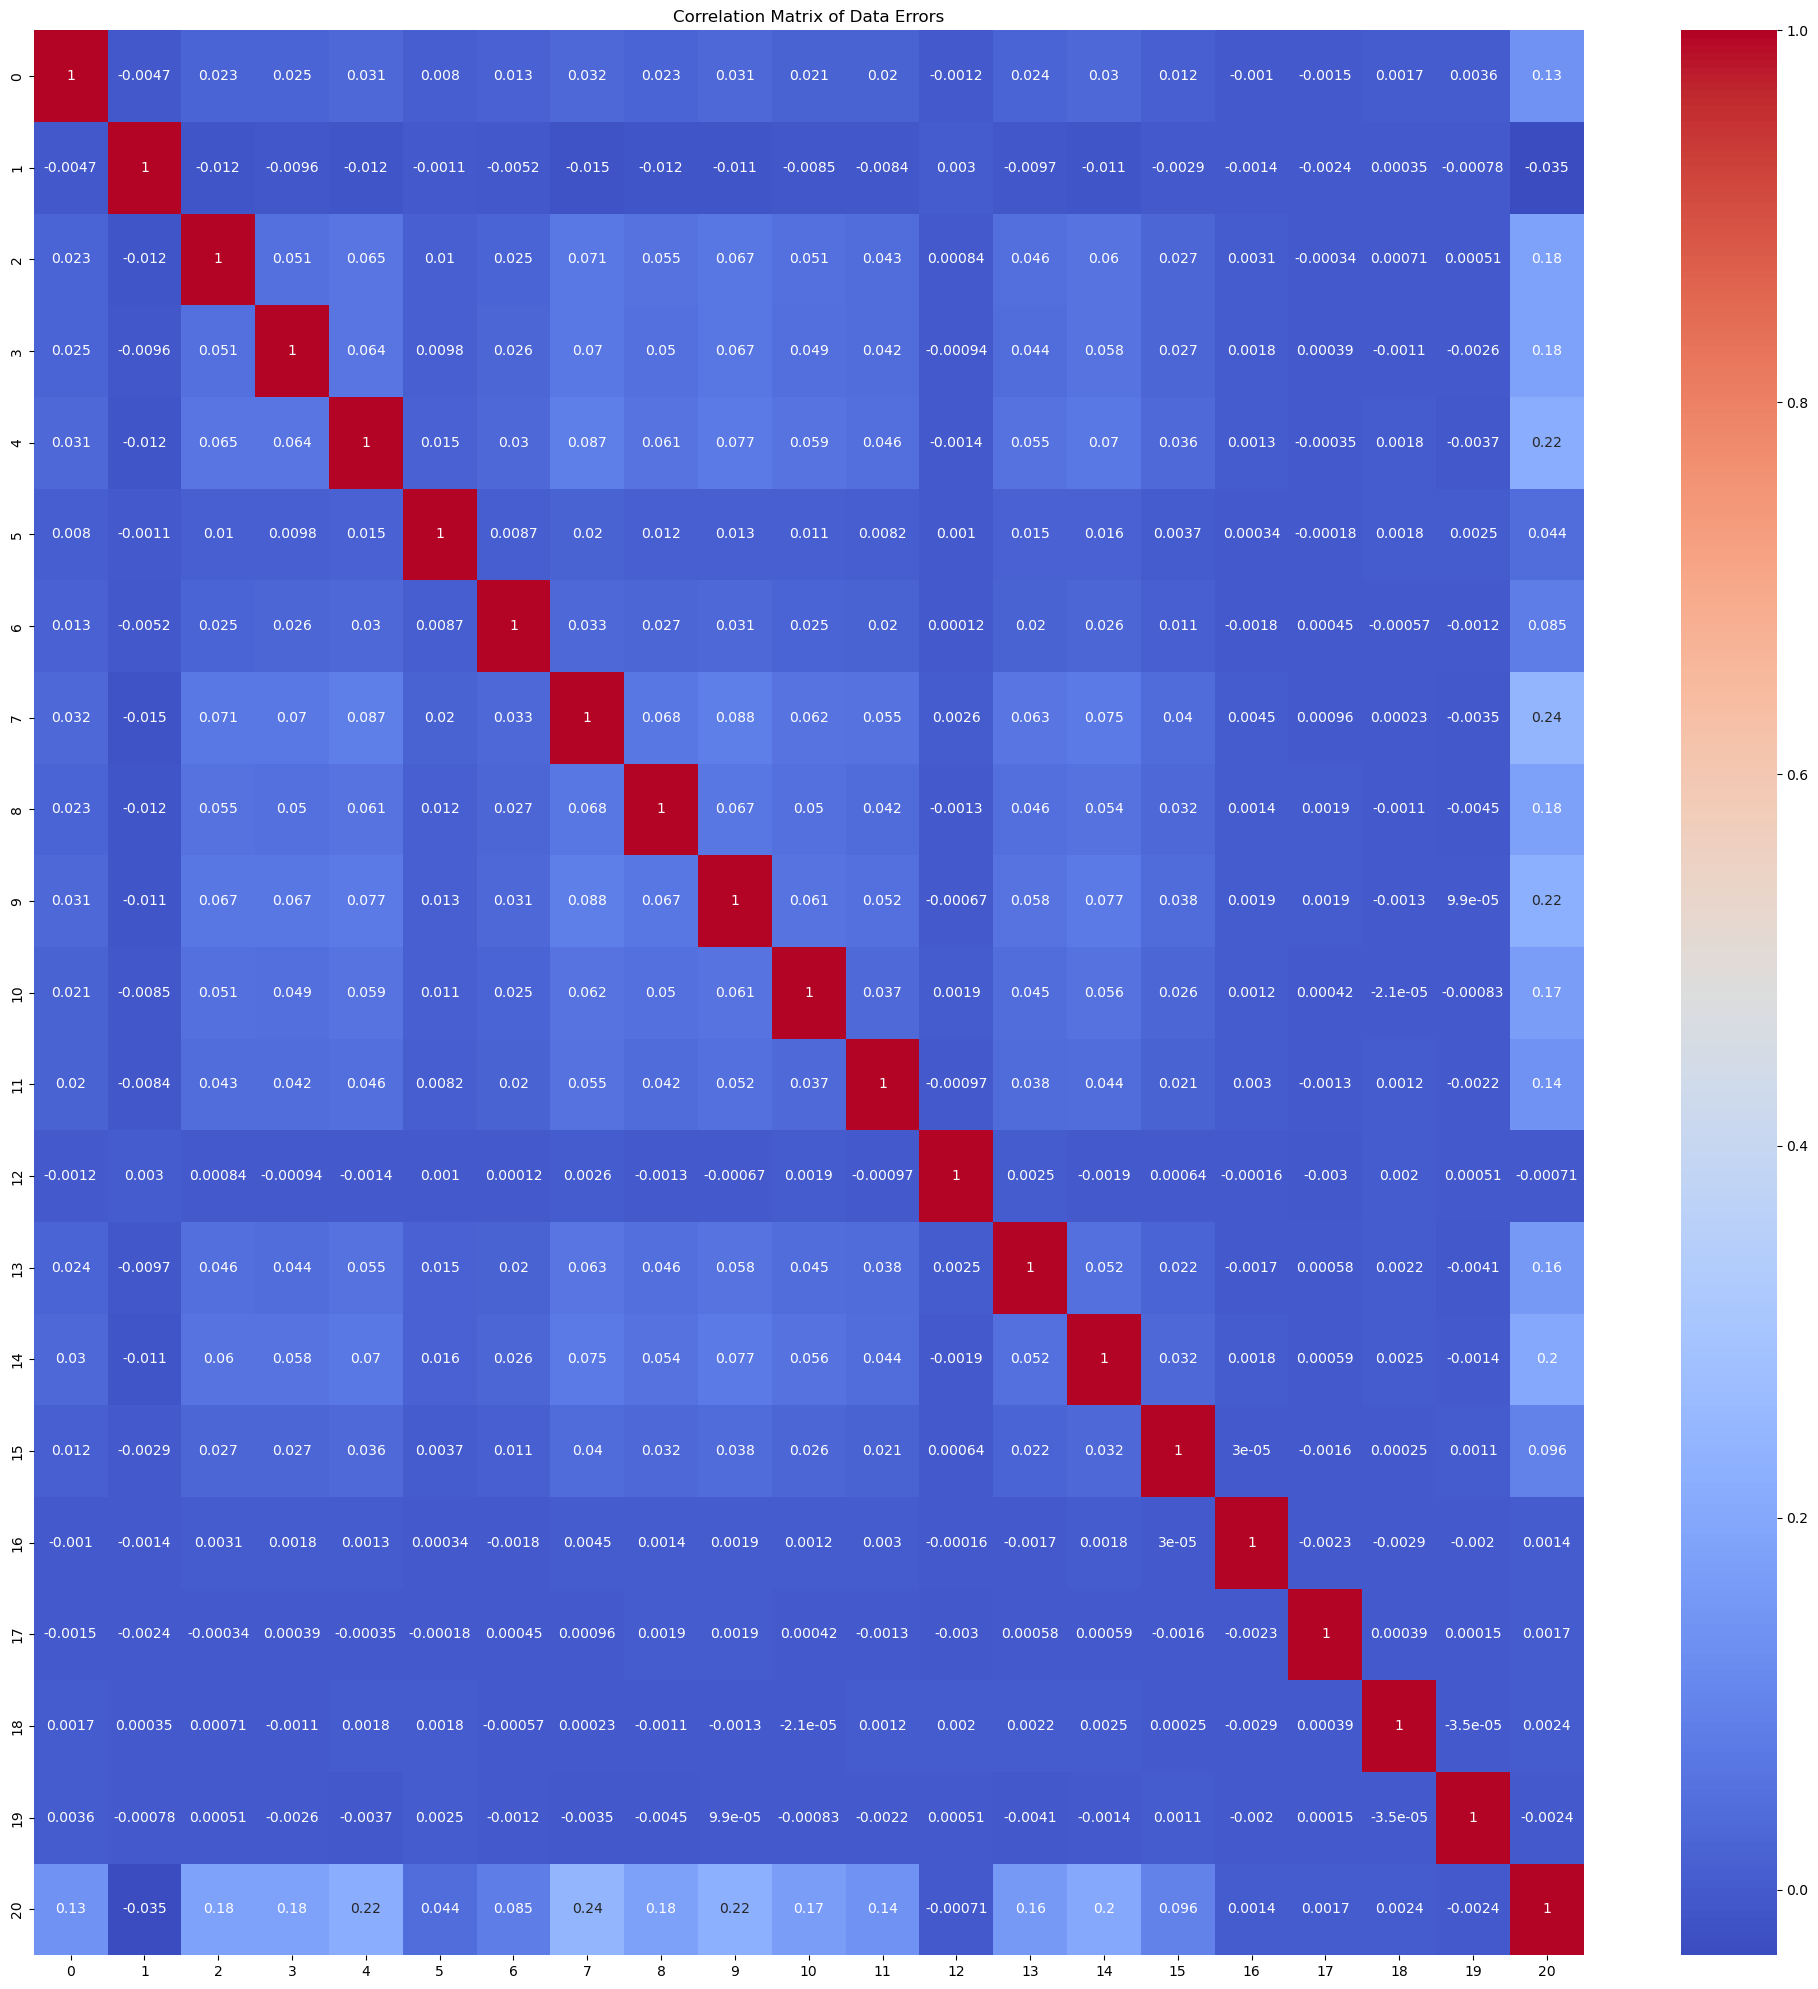

In [16]:
# Calculate the correlation matrix
corr_matrix = data.corr()

# Plot the heatmap using seaborn
plt.figure(figsize=(25, 25))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Data Errors")
plt.show()

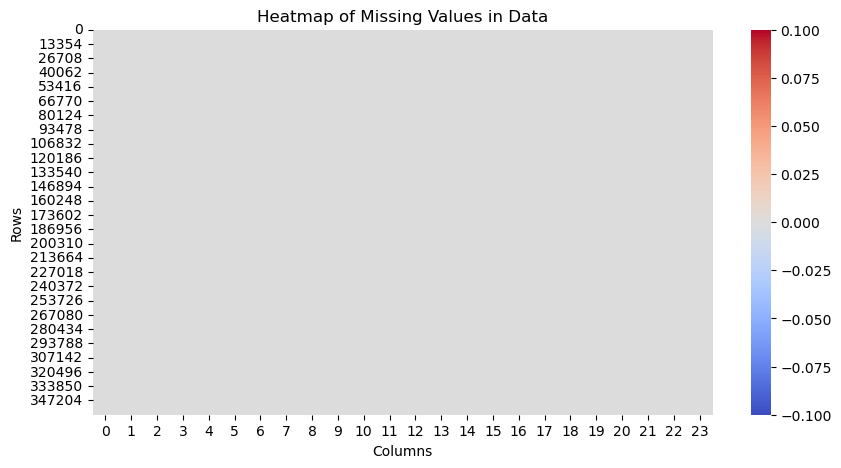

In [17]:
# Plot the heatmap using seaborn
plt.figure(figsize=(10, 5))
sns.heatmap(data.isnull(), cmap='coolwarm')
plt.title("Heatmap of Missing Values in Data")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

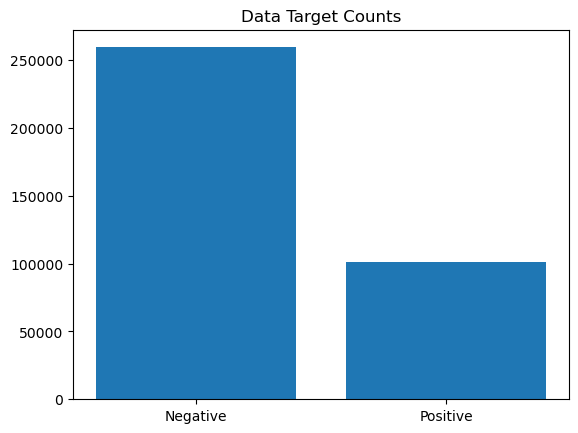

In [18]:
target_count = data['Target'].value_counts()
plt.bar(target_count.index, target_count.values)
plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"])
plt.title("Data Target Counts")
plt.show()

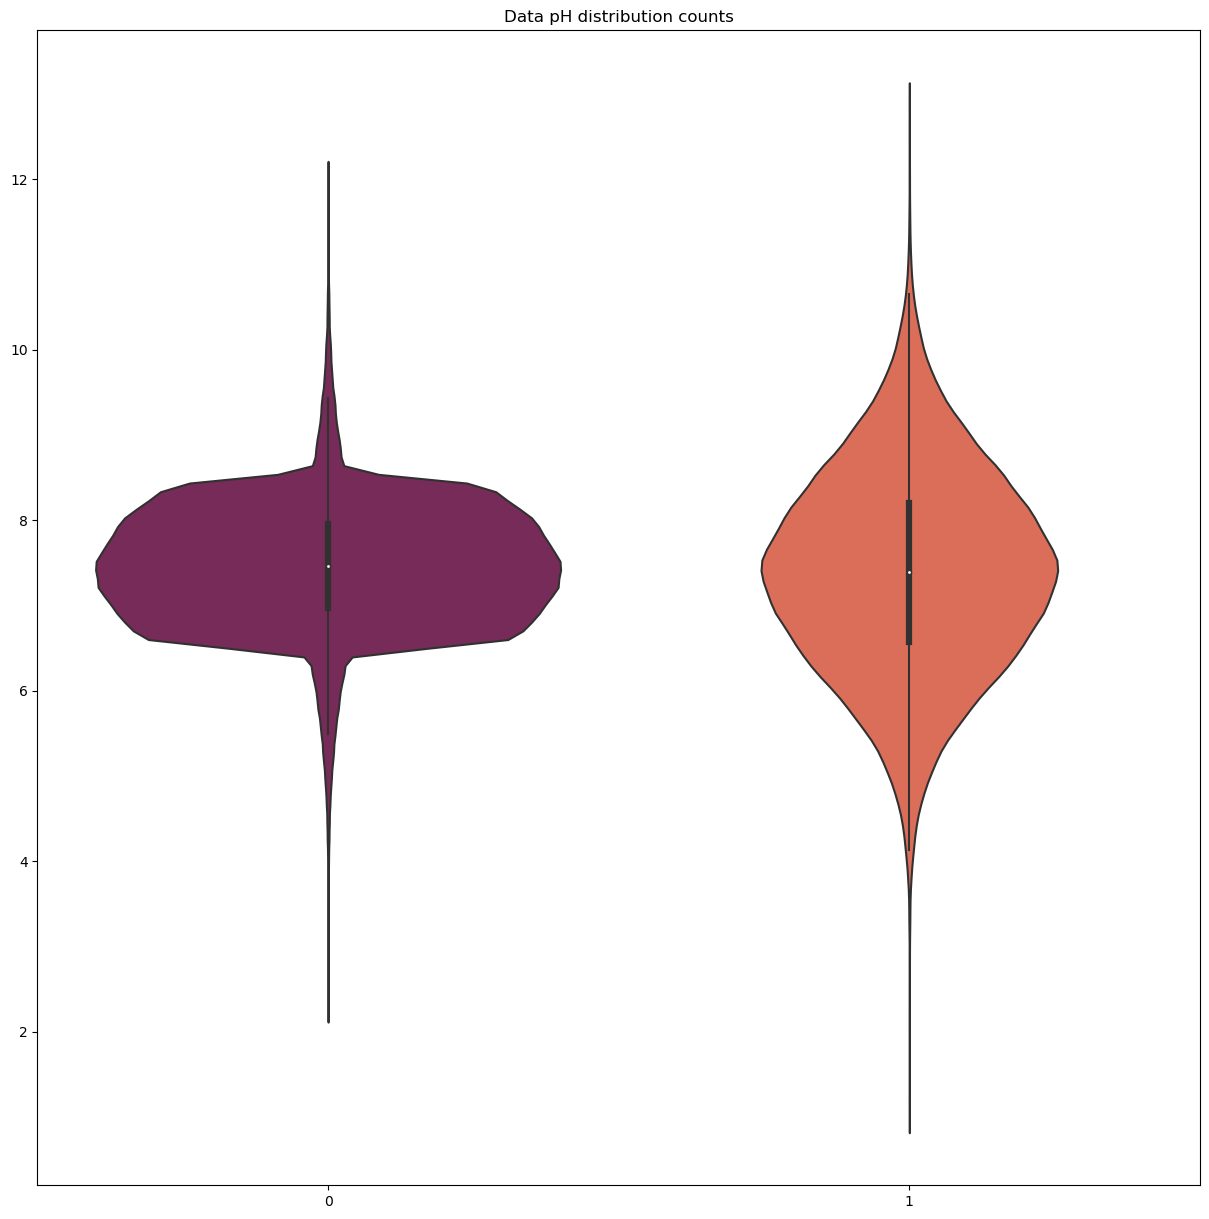

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
sns.violinplot(x=data['Target'].values, y=data['pH'].values, data=data, palette='rocket')
#sns.violinplot(x=data['Target'], y=data['pH'], data=data, palette='rocket')
plt.title('Data pH distribution counts')
plt.show()


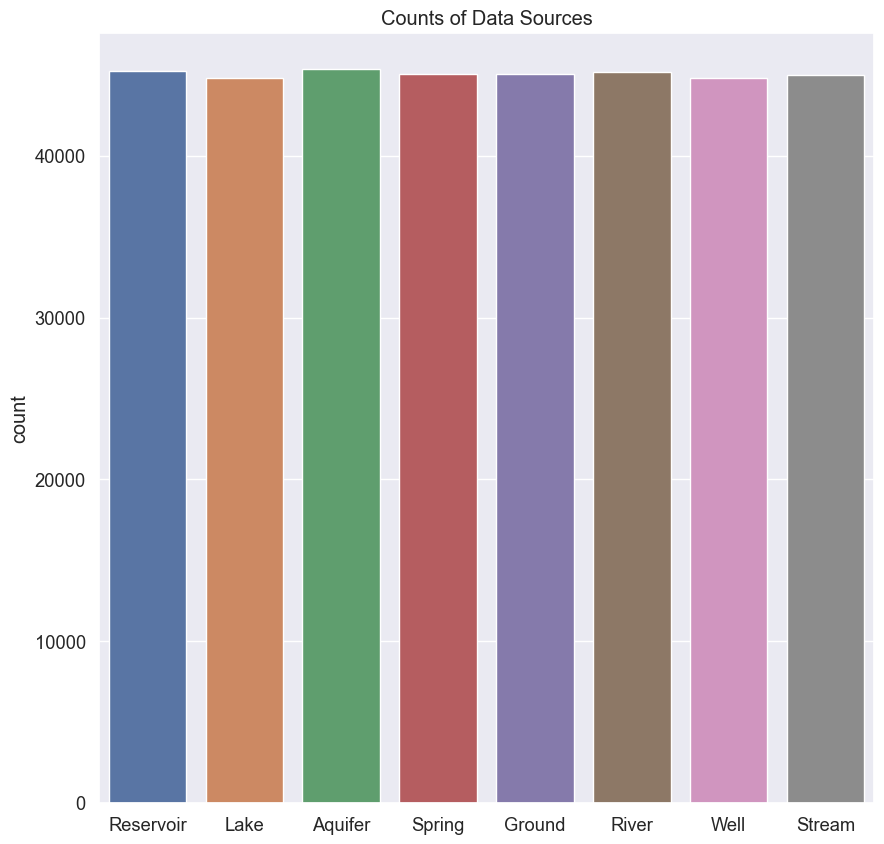

In [58]:
#Plot the unique values

# source_counts = data['Source'].value_counts()

# plt.title('Source count')
# plt.show()

plt.figure(figsize=(10, 10))
sns.countplot(x=data["Source"].values, data=data)
plt.title('Counts of Data Sources')
plt.show()

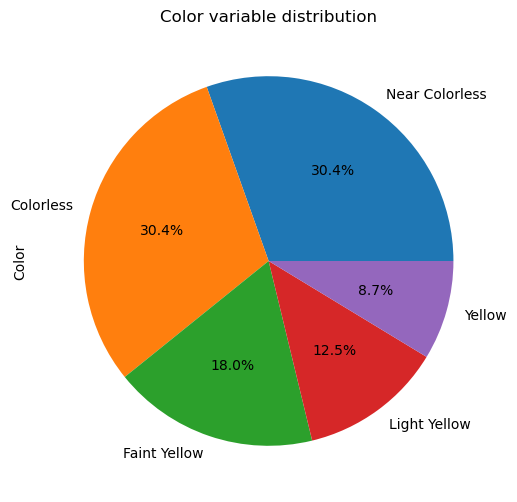

In [20]:
# Pie chart of color variable distribution
plt.figure(figsize=(6,6))
data['Color'].value_counts().plot(kind='pie',autopct='%1.1f%%')
plt.title('Color variable distribution')
plt.show()

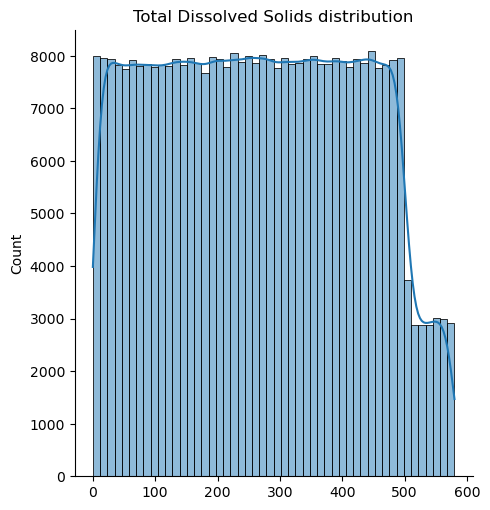

In [35]:
# Distribution plot of Total Dissolved Solids
sns.displot(x=data["Total Dissolved Solids"].values, kde=True, bins=50, data=data)
plt.title("Total Dissolved Solids distribution")
plt.show()

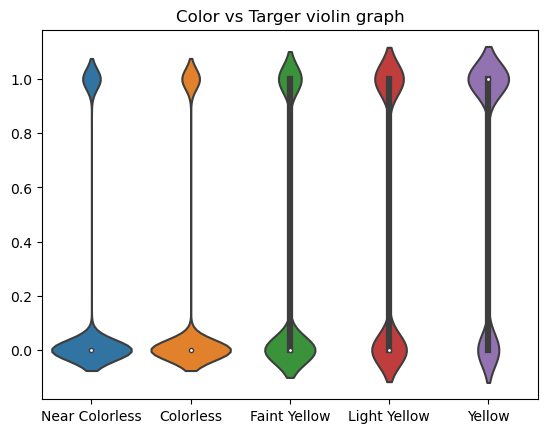

In [37]:
sns.violinplot(x=data["Color"].values, y=data["Target"].values, data=data)
plt.title("Color vs Targer violin graph")
plt.show()

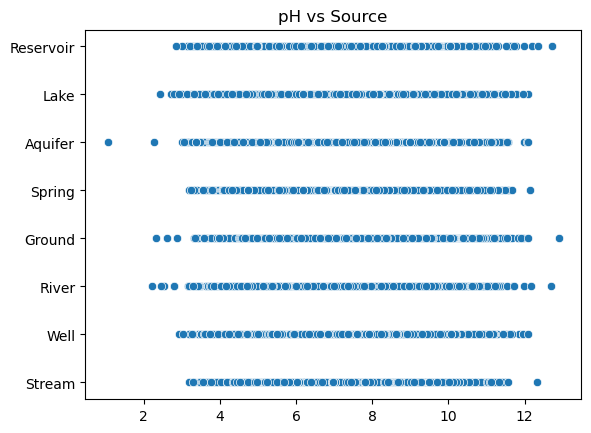

In [38]:
sns.scatterplot(x=data["pH"].values, y=data["Source"].values, data=data, cmap='coolwarm')
plt.title("pH vs Source")
plt.show()

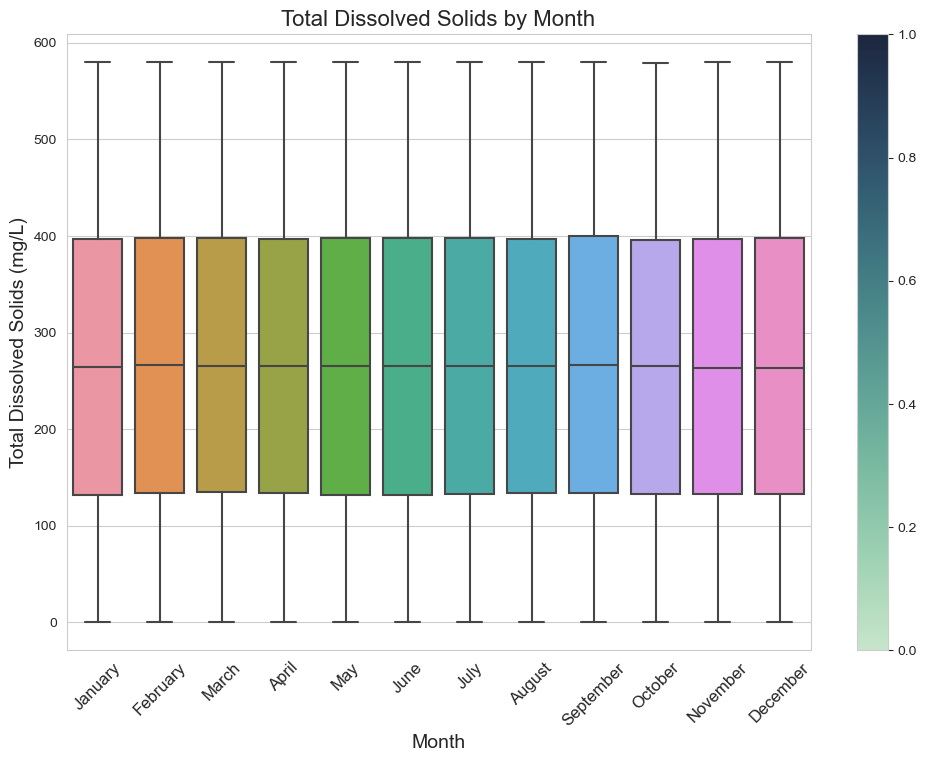

In [40]:
# sns.boxplot(x="Month", y="Total Dissolved Solids", data=data)
# plt.title("pH vs Source")
# plt.show()

# Set the figure size and background color
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Define the color map
cmap = sns.cubehelix_palette(rot=-.4, as_cmap=True)

# Create the boxplot
sns.boxplot(x=data["Month"].values, y=data["Total Dissolved Solids"].values, data=data)

# Set the title and labels
plt.title("Total Dissolved Solids by Month", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Total Dissolved Solids (mg/L)", fontsize=14)

# Set the tick labels for x-axis
month_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
plt.xticks(np.arange(12), month_order, fontsize=12, rotation=45)

# Add the color bar legend
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
plt.colorbar(sm)

# Show the plot
plt.show()


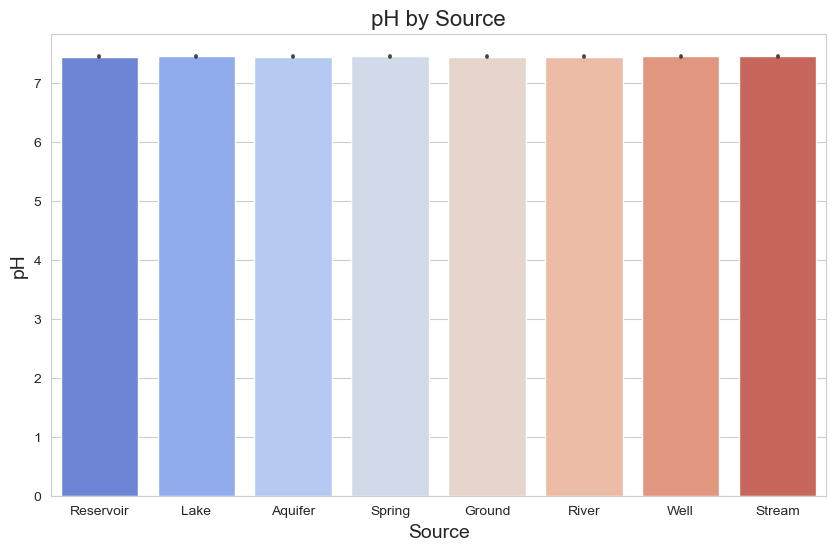

In [41]:
# Bar plot of pH by Source
plt.figure(figsize=(10,6))
sns.barplot(x=data["Source"].values, y=data["pH"].values, data=data, palette="coolwarm")
plt.title("pH by Source", fontsize=16)
plt.xlabel("Source", fontsize=14)
plt.ylabel("pH", fontsize=14)
plt.show()

In [42]:
# subset the data with element data and relevant columns
element_data = data[['pH', 'Iron', 'Nitrate', 'Chloride', 'Lead', 'Zinc', 'Turbidity', 'Fluoride',
                    'Copper', 'Odor', 'Sulfate', 'Conductivity', 'Chlorine', 'Manganese',
                    'Total Dissolved Solids', 'Water Temperature', 'Air Temperature', 'Source', 'Month','Time of Day', 'Day' ]]

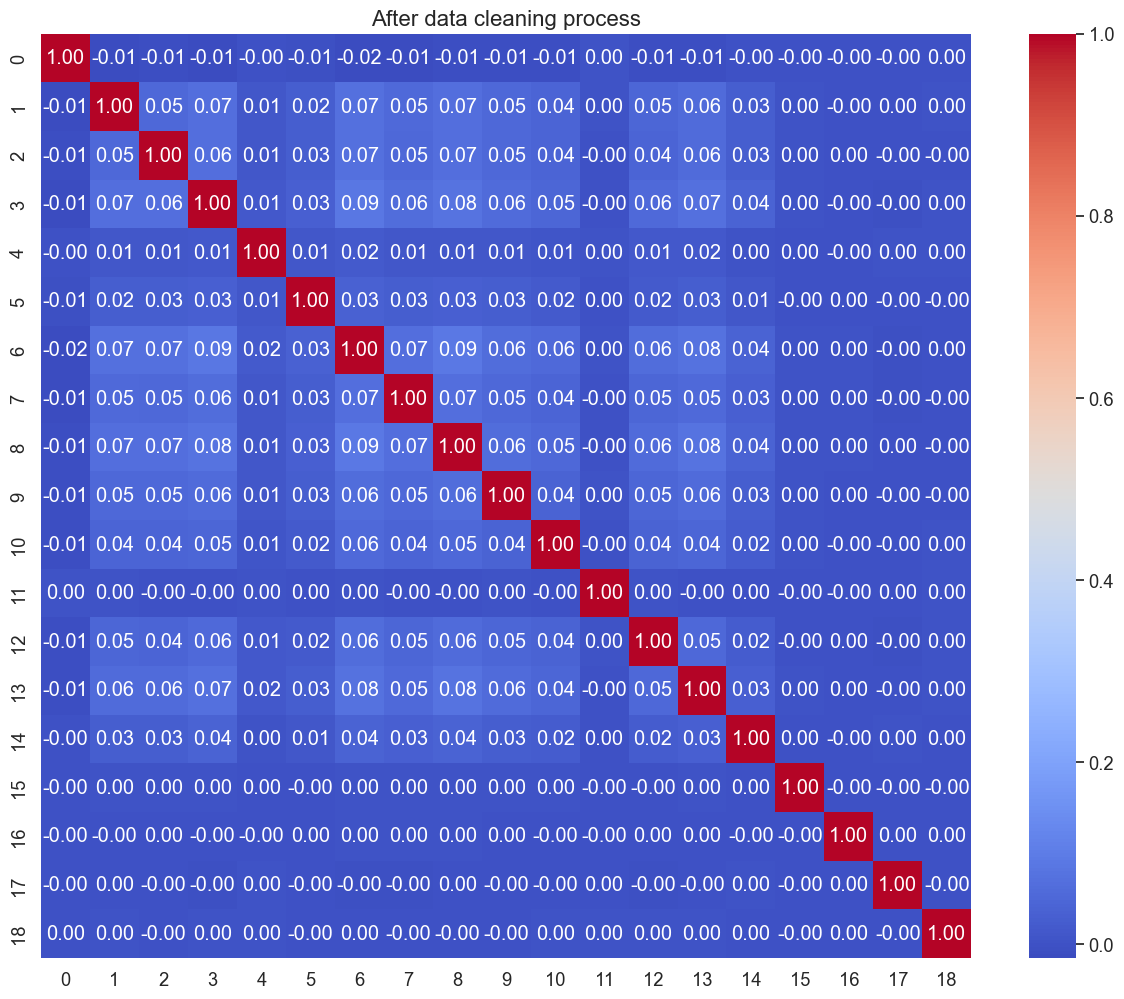

In [46]:
# plot the heatmap for correlation between elements
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(element_data.corr(), cmap='coolwarm', annot=True, fmt='.2f', ax=ax)
plt.title("After data cleaning process", fontsize=16)
plt.show()

## 4. Time Series Analysis
In this step, we analyze the data as a time series to understand its temporal properties and trends. We use statistical techniques to detect patterns, seasonality, and other important aspects of the data that can help us make informed decisions.

In [47]:
# merge Month, Day, and Time of Day
def merge_date(row):
    try:
        year = 2022
        month = mpd.to_datetime(row['Month'], format='%B').month
        day = int(row['Day'])
        if day > calendar.monthrange(year, month)[1]: # check if day is valid for the month
            return 'Invalid date'
        else:
            date_str = datetime(year=year, month=month, day=day).strftime('%Y-%m-%d')
            time_str = str(int(row['Time of Day'])).zfill(2) + ':00:00'
            return date_str + ' ' + time_str
    except ValueError:
        return 'Invalid date'

data['Date'] = data.apply(merge_date, axis=1)

In [48]:
data = data.drop(['Month', 'Day', 'Time of Day'], axis=1)

In [49]:
# Drop the "Index" column as it is redundant
data.drop("Index", axis=1, inplace=True)

In [50]:
# Check for missing values and interpolate them
data.isna().sum() # Count the missing values for each column
data = data.interpolate(method="linear") # Interpolate missing values linearly

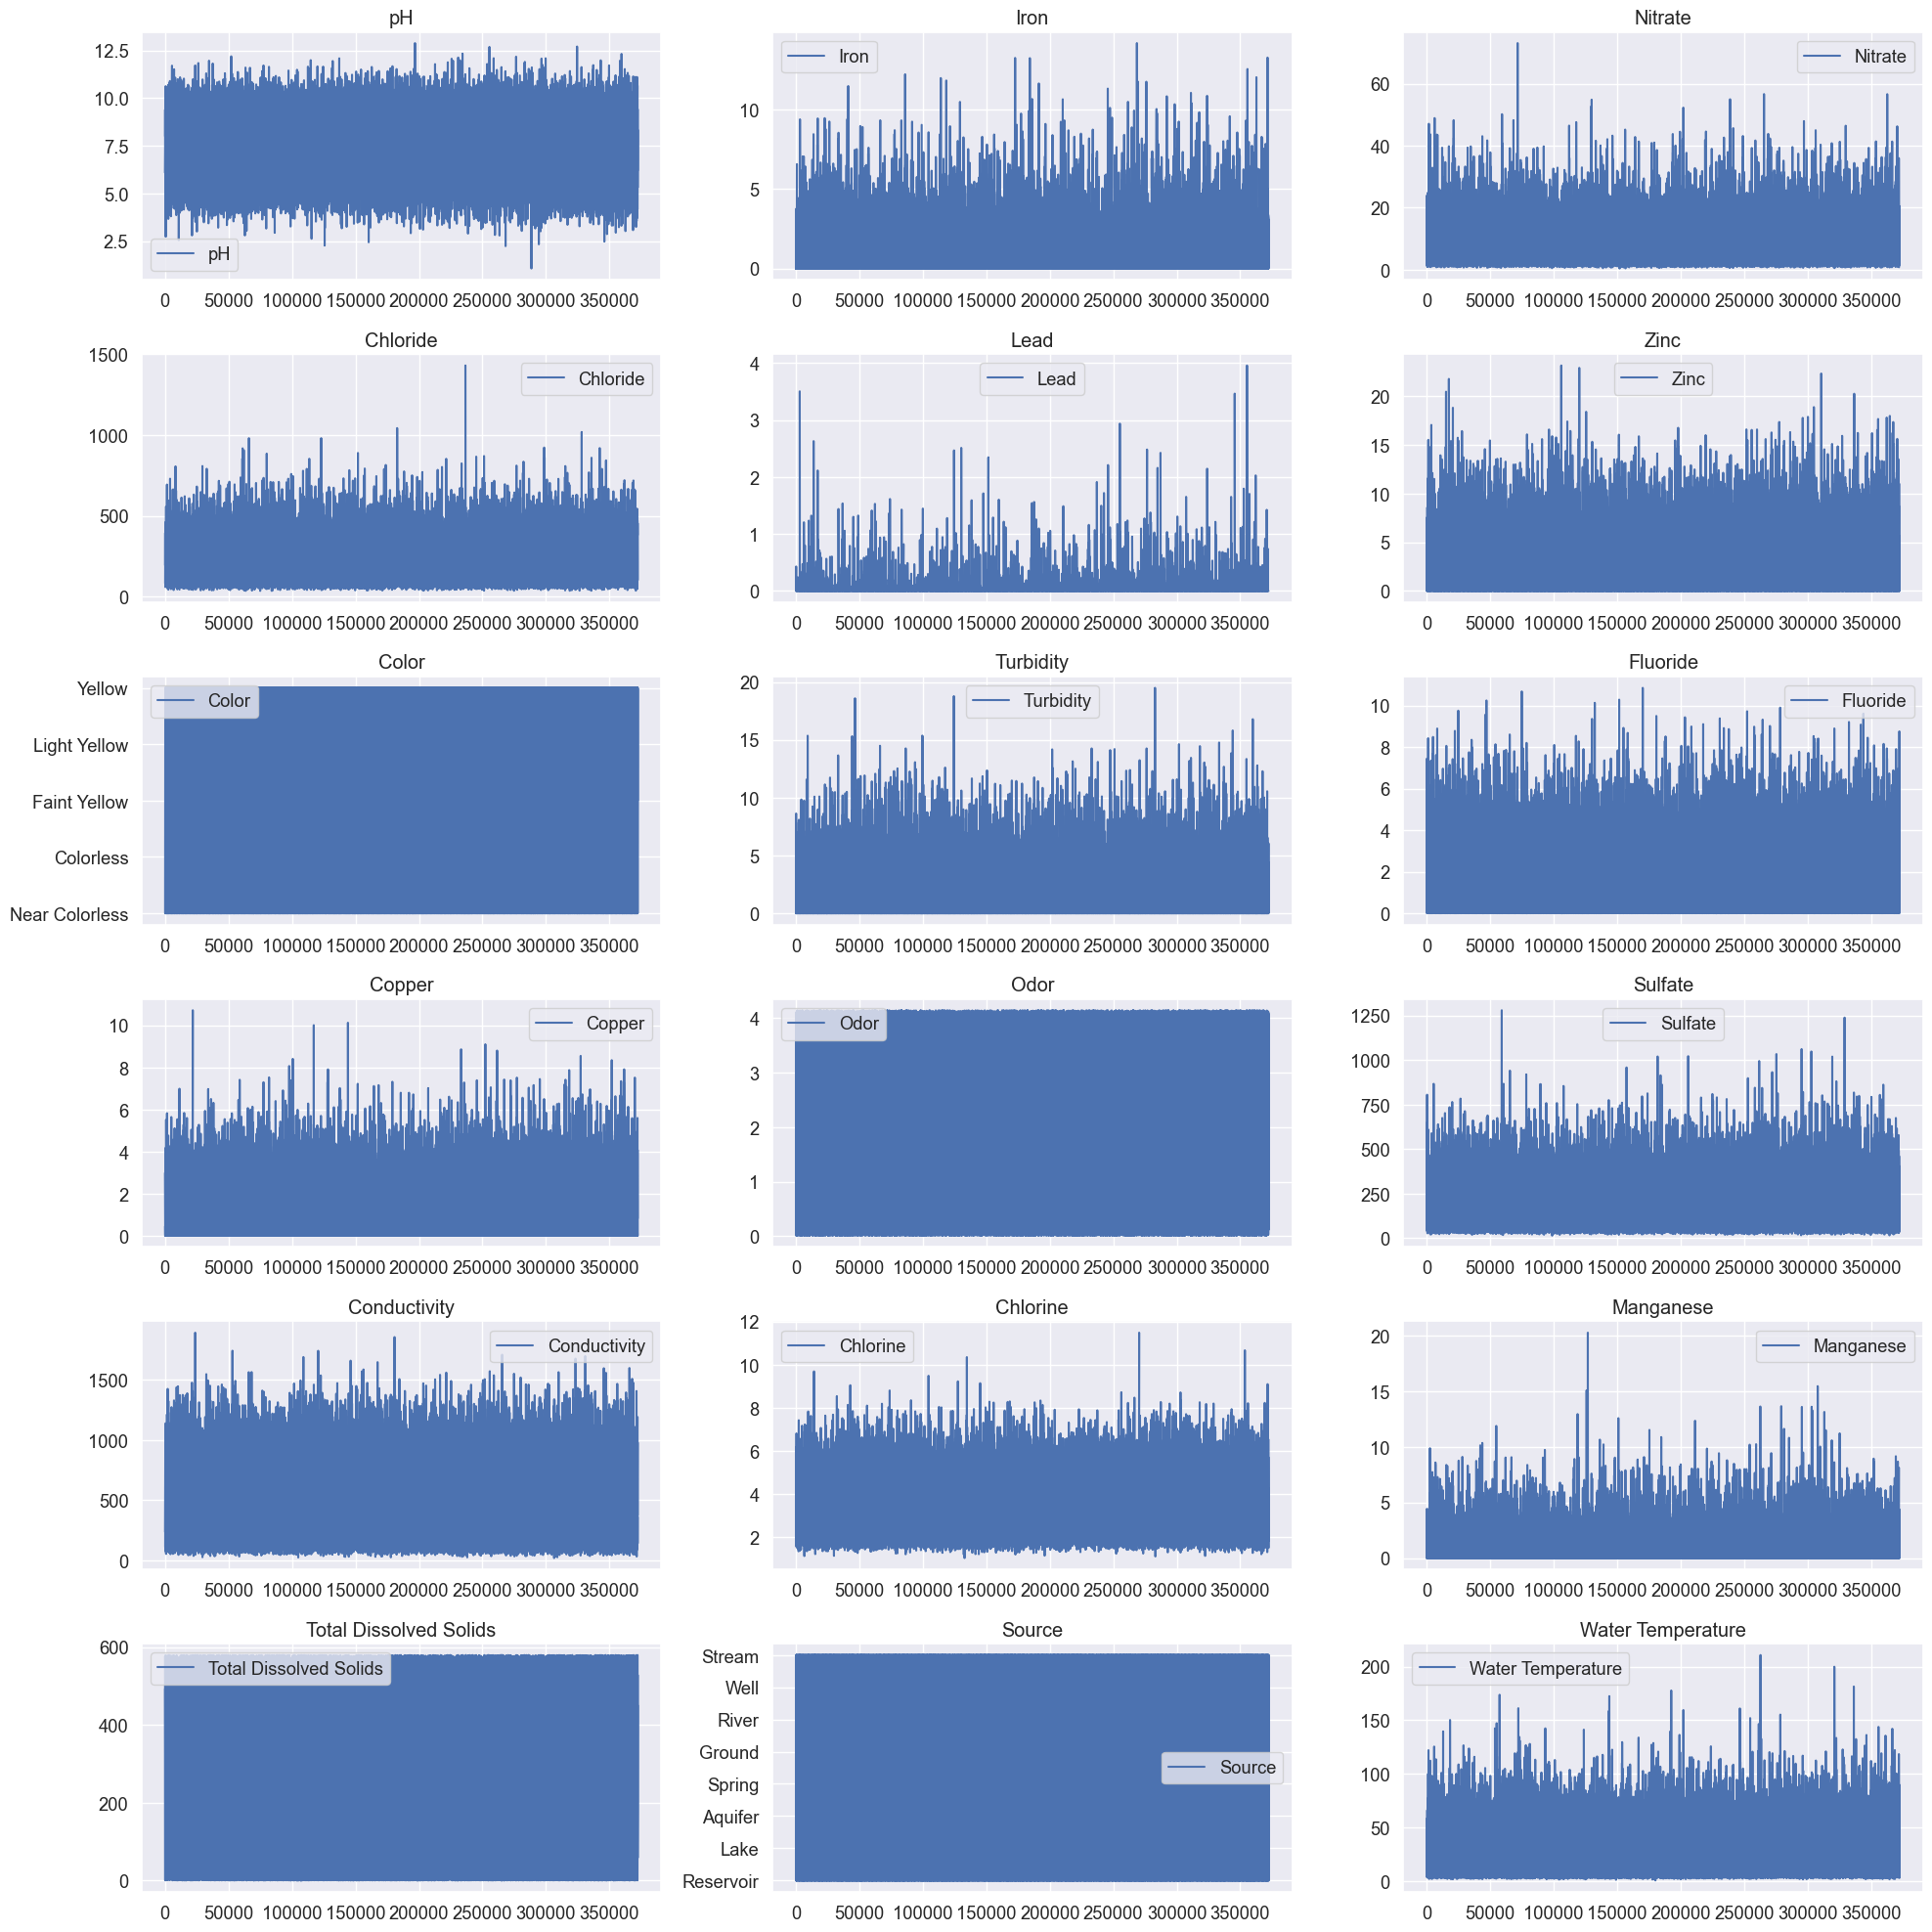

In [51]:
plt.rcParams['agg.path.chunksize'] = 1000
plt.rcParams['path.simplify_threshold'] = 0.2

# Visualize the time series for each variable
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(20,20))
for i, ax in enumerate(axs.flatten()):
    if i < len(data.columns):
        col = data.columns[i]
        ax.plot(data.index, data[col], label=col)
        ax.set_title(col)
        ax.legend()
plt.tight_layout()
plt.show()

In [53]:
# Decompose the time series into trend, seasonality, and residual components
decomposition = seasonal_decompose(data["Target"], period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

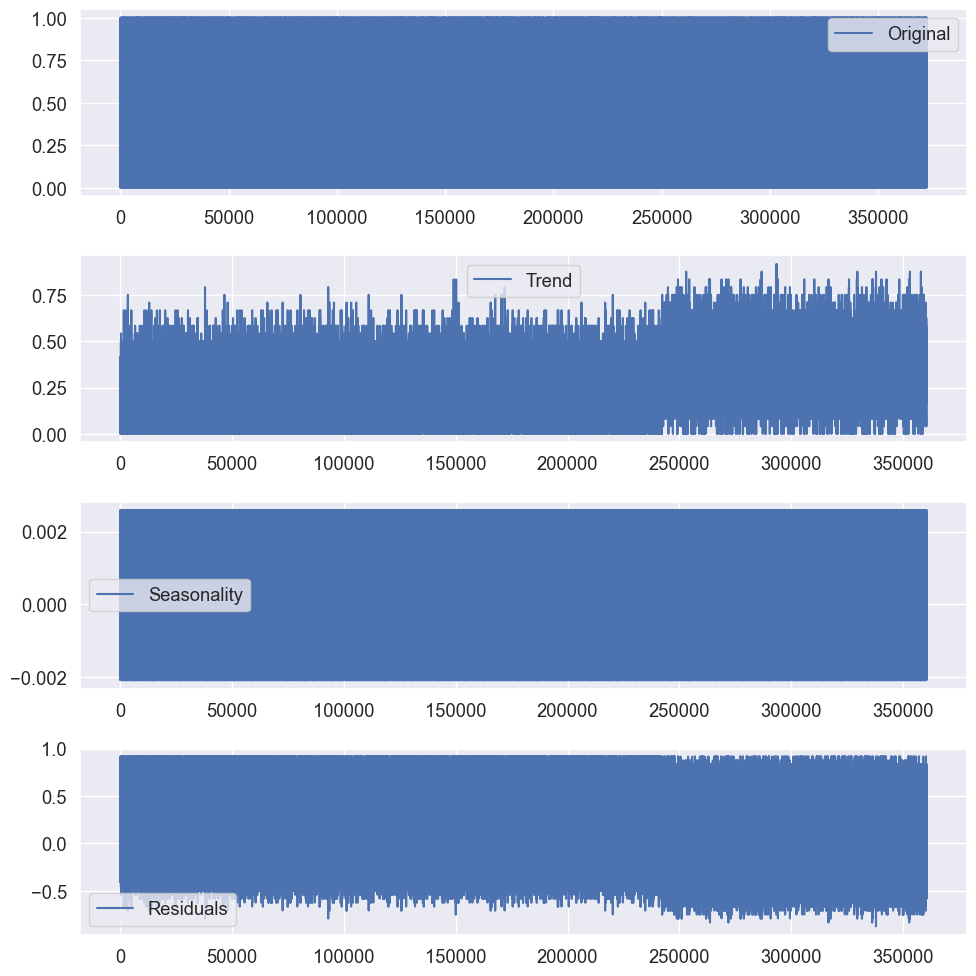

In [54]:
# Visualize the decomposed components
plt.figure(figsize=(10,10))
plt.subplot(411)
plt.plot(data["Target"], label="Original")
plt.legend()
plt.subplot(412)
plt.plot(trend, label="Trend")
plt.legend()
plt.subplot(413)
plt.plot(seasonal, label="Seasonality")
plt.legend()
plt.subplot(414)
plt.plot(residual, label="Residuals")
plt.legend()
plt.tight_layout()
plt.show()

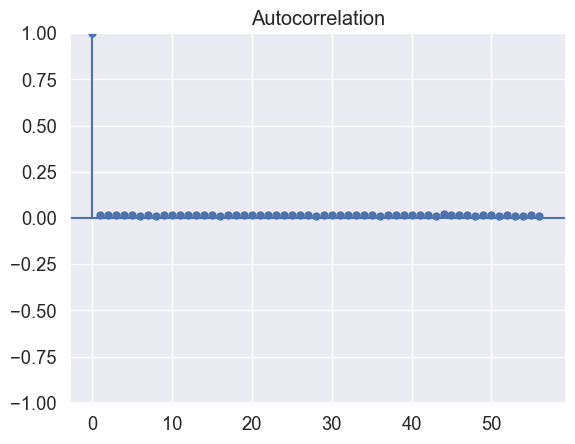

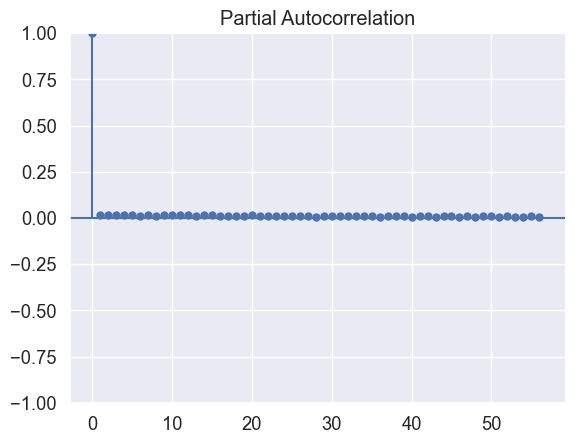

In [59]:
# Plot the autocorrelation and partial autocorrelation functions
plot_acf(data["Target"])
plt.show()
plot_pacf(data["Target"])
plt.show()

In [61]:
# Fit an ARIMA model to the time series
model = ARIMA(data["Target"].values, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               360551
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -220096.570
Date:                Fri, 03 Mar 2023   AIC                         440199.141
Time:                        18:20:58   BIC                         440231.527
Sample:                             0   HQIC                        440208.435
                             - 360551                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0003      0.002     -0.177      0.859      -0.004       0.003
ma.L1         -0.9996   4.86e-05  -2.06e+04      0.000      -1.000      -0.999
sigma2         0.1985      0.001    300.067      0.0

In [62]:
# Save the data
data.to_csv('./data/dataprocess.csv', index=False)